In [5]:
import torch
import torchvision
from torch import nn, optim
import numpy as np
import sys
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import random
import wandb
import os
import tempfile
import shutil
from PIL import Image
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import cityscapesscripts.download.downloader as cssd
from torch.utils.data import DataLoader
from io import BytesIO
from base64 import b64encode
from typing import Dict
#from sklearn.metrics import confusion_matrix
import unet_baseline
import siamese
import prepare_data as pd

In [6]:
#%run -i prepare_data.ipynb

ModuleNotFoundError: No module named 'nbformat'

At least one of the validation sets still exist
Preprocessed directory already exists: d:\Github projects\5aua0-2022-group-32\data\cityscapes\labels_256_128
Preprocessed directory already exists: d:\Github projects\5aua0-2022-group-32\data\cityscapes\images_256_128
Preprocessing 
Preprocessed directory already exists: d:\Github projects\5aua0-2022-group-32\data\cityscapes\labels_val_256_128
Preprocessed directory already exists: d:\Github projects\5aua0-2022-group-32\data\cityscapes\images_val_256_128
Preprocessing 
Preprocessed directory already exists: d:\Github projects\5aua0-2022-group-32\data\bdd100k\labels_256_128
Preprocessed directory already exists: d:\Github projects\5aua0-2022-group-32\data\bdd100k\images_256_128
Preprocessing 
Preprocessed directory already exists: d:\Github projects\5aua0-2022-group-32\data\acdc\labels_256_128
Preprocessed directory already exists: d:\Github projects\5aua0-2022-group-32\data\acdc\images_256_128
Preprocessing 
Preprocessed directory already

Subset,Amount,Size,Input sample,Truth sample
css,2975,256×128,,
css_val,500,256×128,,
bdd,1000,256×128,,
acdc,406,256×128,,
map,2000,256×128,,

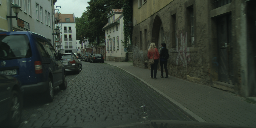
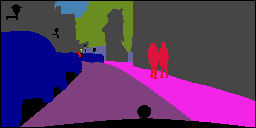
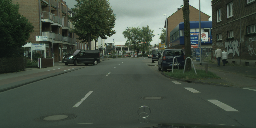
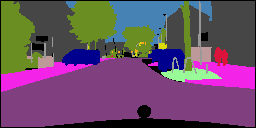
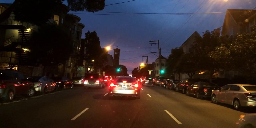
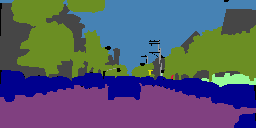
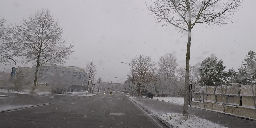
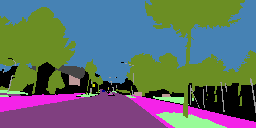
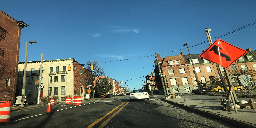
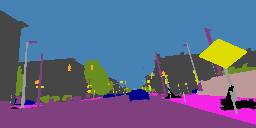

In [ ]:
pd.prep_init()

In [ ]:
def compute_iou_cat(output: torch.Tensor, truths: torch.Tensor):
    iou_cat = np.zeros(7)
    iou_cat_count = np.zeros(7)
    class_ids = [i for i in range(19)]
    #add confusion matrices together and calculate average
    matrix = confusion_matrix(truths.flatten(), output.flatten(), labels=class_ids)
    col_totals = [sum(x) for x in zip(*matrix)]
    row_totals = list(map(lambda row:sum(row), matrix))
    for obj in classes:
        id = obj.trainId
        cat_id = obj.categoryId
        if id is 255:
            continue
        
        tp = matrix[id][id]
        div = col_totals[id]+row_totals[id]-tp
        if tp and div is not 0:
            iou_cat[cat_id-1] = iou_cat[cat_id-1] + tp/div
        
        if id in truths:
            iou_cat_count[cat_id-1] = iou_cat_count[cat_id-1] + 1

    iou_cat = np.divide(iou_cat, iou_cat_count)
    iou_cat = np.nan_to_num(iou_cat)
    
    return iou_cat
        
def compute_iou(matrix, lengths):
    iou_class = np.zeros(19)
    col_totals = [sum(x) for x in zip(*matrix)]
    row_totals = list(map(lambda row:sum(row), matrix))
    for obj in classes:
        id = obj.trainId
        if id is 255:
            continue
        
        tp = matrix[id][id]
        div = col_totals[id]+row_totals[id]-tp
        if tp and div is not 0:
            iou_class[id-1] = iou_class[id-1] + tp/div

    iou_class = np.divide(iou_class, 19)
    iou_class = np.nan_to_num(iou_class)
    
    return iou_class

def intersect_and_union(pred_label: torch.tensor, label: torch.tensor,
                            num_classes: int = 19, ignore_index: int = 255):
        """Calculate Intersection and Union.

        Args:
            pred_label (torch.tensor): Prediction segmentation map
                or predict result filename. The shape is (H, W).
            label (torch.tensor): Ground truth segmentation map
                or label filename. The shape is (H, W).
            num_classes (int): Number of categories.
            ignore_index (int): Index that will be ignored in evaluation.

        Returns:
            torch.Tensor: The intersection of prediction and ground truth
                histogram on all classes.
            torch.Tensor: The union of prediction and ground truth histogram on
                all classes.
            torch.Tensor: The prediction histogram on all classes.
            torch.Tensor: The ground truth histogram on all classes.
        """

        mask = (label != ignore_index)
        pred_label = pred_label[mask]
        label = label[mask]

        intersect = pred_label[pred_label == label]
        area_intersect = torch.histc(
            intersect.float(), bins=(num_classes), min=0,
            max=num_classes - 1).cpu()
        area_pred_label = torch.histc(
            pred_label.float(), bins=(num_classes), min=0,
            max=num_classes - 1).cpu()
        area_label = torch.histc(
            label.float(), bins=(num_classes), min=0,
            max=num_classes - 1).cpu()
        area_union = area_pred_label + area_label - area_intersect
        return area_intersect, area_union, area_pred_label, area_label
        

In [ ]:
class MeanIOU(object):
  def __init__(self, valid_classes, ignore_index=-1, max_label_value=None):
    self.valid_classes = valid_classes
    self.num_classes = len(self.valid_classes)
    self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))
    self.ignore_index = ignore_index

    # Create mapping for label ids to eval ids (which are [0, num_classes))
    if max_label_value is None:
      max_label_value = max(self.valid_classes)
    self.lids2eval_ids = np.full(max_label_value+1, ignore_index, dtype=np.int32)
    for i in range(len(self.valid_classes)):
      self.lids2eval_ids[valid_classes[i]] = i
    self.lids2eval_ids = np.append(self.lids2eval_ids, ignore_index)
    #print(self.lids2eval_ids)


  def update(self, preds, labels):
    # assign ignore index also to other ignored items
    invalid_class_mask = np.logical_not(np.isin(labels, self.valid_classes))
    labels[invalid_class_mask] = len(self.lids2eval_ids)-1

    if np.any(np.logical_not(np.isin(preds, self.valid_classes))):
      present = np.unique(preds[np.logical_not(np.isin(preds, self.valid_classes))])
      raise ValueError("There are invalid classes in the prediction:", present)

    # Map prediction and labels to eval_ids
    seg_gt = self.lids2eval_ids[labels]
    seg_pred = self.lids2eval_ids[preds]

    non_ignore_index = seg_gt != self.ignore_index

    seg_gt = seg_gt[non_ignore_index]
    seg_pred = seg_pred[non_ignore_index]

    self.confusion_matrix += self.get_confusion_matrix(seg_gt, seg_pred, self.num_classes)


  def result(self):
    pos = self.confusion_matrix.sum(1)
    res = self.confusion_matrix.sum(0)
    tp = np.diag(self.confusion_matrix)

    IU_array = (tp / np.maximum(1.0, pos + res - tp))
    mean_IU = IU_array.mean()

    evaluation_results = {'meanIU': mean_IU, 'IU_array': IU_array, 'confusion_matrix': self.confusion_matrix}

    return evaluation_results

    def convert_confusion_matrix(confusion_matrix):
      cls_sum = confusion_matrix.sum(axis=1)
      confusion_matrix = confusion_matrix / cls_sum.reshape((-1, 1))
      return confusion_matrix

    print('evaluate segmentation:')
    meanIU = evaluation_results['meanIU']
    IU_array = evaluation_results['IU_array']
    confusion_matrix = convert_confusion_matrix(evaluation_results['confusion_matrix'])
    print('IOU per class:')
    for i in range(len(IU_array)):
      print('{}: '.format(i) + '%.5f' % IU_array[i])
    print('meanIOU: %.5f' % meanIU)
    np.set_printoptions(precision=3, suppress=True, linewidth=200)
    import re
    confusion_matrix = re.sub('[\[\]]', '', np.array2string(confusion_matrix, separator='\t'))

    return {'meanIOU': float(mean_IU),
            'IOUs': list(IU_array)}

  def get_confusion_matrix(self, gt_label, pred_label, class_num):
    """
    Calcute the confusion matrix by given label and pred
    :param gt_label: the ground truth label
    :param pred_label: the pred label
    :param class_num: the nunber of class
    :return: the confusion matrix
    """
    index = (gt_label * class_num + pred_label).astype('int32')
    label_count = np.bincount(index)
    confusion_matrix = np.zeros((class_num, class_num))

    for i_label in range(class_num):
      for i_pred_label in range(class_num):
        cur_index = i_label * class_num + i_pred_label
        if cur_index < len(label_count):
          confusion_matrix[i_label, i_pred_label] = label_count[cur_index]

    return confusion_matrix

In [ ]:
class Trainer:
    def __init__(self, model: nn.Module, ds_split: Dict[str,SegmentationDataset]):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.model = model.to(self.device)
        self.ds_split = ds_split

        #self.optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        #self.critereon = nn.MSELoss()
        self.critereon = nn.CrossEntropyLoss(ignore_index=255)
        self.critereon_sc = nn.CrossEntropyLoss()
        self.loss_contrastive = siamese.ContrastiveLoss()


    def train_epoch(self, dl, alpha = 0, graphs = False):
        self.model.train()

        epoch_metrics = {
            "loss": [],
        }

        # Create a progress bar using TQDM
        sys.stdout.flush()
        with tqdm(total=len(dl.dataset), desc=f'Training') as pbar:
            for _, (inputs, truths) in enumerate(dl):
                self.optimizer.zero_grad()
                
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)

                # Run model on the inputs
                inputs_random = torchvision.transforms.ColorJitter(0.8, 0.8, 0.8, 0.3).forward(inputs)
                output = self.model(inputs_random)
                
                loss = self.critereon(output, truths)

                if alpha is not 0:
                    inputs_random = torchvision.transforms.ColorJitter(0.8, 0.8, 0.8, 0.3).forward(inputs)
                    output_2 = self.model(inputs_random)
                    #loss = loss + alpha * self.critereon_sc(output_2, output)
                    loss = (loss + self.critereon(output_2, truths)) / 2 + alpha * self.loss_contrastive(output, output_2)

                loss.backward()
                nn.utils.clip_grad_value_(self.model.parameters(), 0.1)
                self.optimizer.step()

                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.detach(),
                }

                # log metrics to wandb
                if graphs:
                    wandb.log({"loss_train": loss})

                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])

                # Add to epoch's metrics
                for k,v in step_metrics.items():
                    epoch_metrics[k].append(v)

                #amount += 1
                #total_loss += step_metrics["loss"]

        sys.stdout.flush()

        # Print mean of metrics
        #total_loss /= amount

        # Return metrics
        # return {
        #     "loss": [total_loss],
        # }

        # Return metrics
        return epoch_metrics
    
    def val_epoch(self, dl, alpha = 0, graphs = False):
        self.model.eval()

        amount = 0
        total_loss = 0

        # Create a progress bar using TQDM
        sys.stdout.flush()
        with tqdm(total=len(dl.dataset), desc=f'Validation') as pbar:
            for _, (inputs, truths) in enumerate(dl):
                self.optimizer.zero_grad()

                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)

                # Run model on the inputs
                inputs_random = torchvision.transforms.ColorJitter(0.8, 0.8, 0.8, 0.3).forward(inputs)
                output = self.model(inputs_random)
                
                loss = self.critereon(output, truths)
                if alpha is not 0:
                    inputs_random = torchvision.transforms.ColorJitter(0.8, 0.8, 0.8, 0.3).forward(inputs)
                    output_2 = self.model(inputs_random)
                    loss = loss + alpha * self.loss_contrastive(output, output_2)
                #compute_iou(output, truths)

                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.detach(),
                }

                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])

                amount += 1
                total_loss += step_metrics["loss"]

        sys.stdout.flush()

        # Print mean of metrics
        total_loss /= amount
        
        # log metrics to wandb  
        if graphs:
            wandb.log({"loss_test": total_loss})

        # Return metrics
        return {
            "loss": [total_loss],
        }

    def fit(self, epochs: int, batch_size:int, graphs = False):
        dl_train = DataLoader(self.ds_split["css"], batch_size=batch_size, shuffle=True)
        dl_val = DataLoader(self.ds_split["css_val"], batch_size=batch_size, drop_last=True)
        
        #df_train = pd.DataFrame()
        #df_val = pd.DataFrame()

        # Train the model for the provided amount of epochs
        for epoch in range(1, epochs+1):
            alpha = 0
            if epoch > 3:
                alpha = 10

            print(f'Epoch {epoch}')
            metrics_val = self.val_epoch(dl_val, alpha=alpha, graphs=graphs)
            #df_val = df_val.append(pd.DataFrame({'epoch': [epoch], **metrics_val}), ignore_index=True)

            metrics_train = self.train_epoch(dl_train, alpha=alpha, graphs=graphs)
            #df_train = df_train.append(pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train}), ignore_index=True)

        # Return a dataframe that logs the training process. This can be exported to a CSV or plotted directly.
        #return df_train, df_val

            
        

In [ ]:
def test_prediction(model: nn.Module, datasets):
    model.eval()
    model = model.cpu()

    template_table = '<table><thead><tr><th>Subset</th><th>Input sample</th><th>Output sample</th><th>Truth sample</th></tr></thead><tbody>{0}</tbody></table>'
    template_row = '<tr><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td></tr>'
    template_img = '<img src="data:image/png;base64,{0}"/>'

    # Display a random sample of each split of the dataset
    rows = []
    for name in datasets:
        ds_sub = ds_split[name]

        # Draw a random sample from the dataset so that we can convert it back to an image
        input, truth = random.choice(ds_sub)

        # Push through our network
        model = model.cpu()
        output = model(input.unsqueeze(0))

        input = TF.to_pil_image(input)
        truth = ds_sub.to_image(truth)
        output = ds_sub.to_image(ds_sub.masks_to_indices(output).squeeze(0))

        # Create a buffer to save each retrieved image into such that we can base64-encode it for diplay in our HTML table
        with BytesIO() as buffer_input, BytesIO() as buffer_truth, BytesIO() as buffer_output:
            input.save(buffer_input, format='png')
            output.save(buffer_output, format='png')
            truth.save(buffer_truth, format='png')

            # Store one row of the dataset
            images = [template_img.format(b64encode(b.getvalue()).decode('utf-8')) for b in (buffer_input, buffer_output, buffer_truth)]
            rows.append(template_row.format(name, *images))

    # Render HTML table
    table = template_table.format(''.join(rows))
    display(HTML(table))


def train_model(model: nn.Module, epochs=10, graphs = False):
    print("Testing training process...")

    if graphs:
        wandb.init(
            # set the wandb project where this run will be logged
            project="Baseline-UNET",
            
            # track hyperparameters and run metadata
            config={
                "learning_rate": 0.01,
                "architecture": "U-NET",
                "dataset": "Cityscapes",
                "epochs": epochs,
            }
        )

    trainer = Trainer(model, ds_split)
    trainer.fit(epochs=epochs, batch_size=25, graphs=graphs)

    if graphs:
        wandb.finish()

def test_model(model: nn.Module, datasets):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    critereon = nn.CrossEntropyLoss(ignore_index=255)

    #template_table = '<table><thead><tr><th>Dataset</th><th>Average</th><th>Flat</th><th>Construction</th><th>Object</th><th>Nature</th><th>Sky</th><th>Human</th><th>Vehicle</th></tr></thead><tbody>{0}</tbody></table>'
    #template_row = '<tr><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td><td>{4}</td><td>{5}</td><td>{6}</td><td>{7}</td><td>{8}</td></tr>'
    class_ids = [i for i in range(19)]

    template_table = '<table><thead><tr><th>Dataset</th><th>Average</th>'
    template_row = '<tr><td>{0}</td><td>{1}</td>'

    classes_sorted = sorted(classes, key=lambda x: x.trainId, reverse=False)
    for ids in class_ids:
        template_table = template_table + '<th>' + classes_sorted[ids].name + '</th>'
        template_row = template_row + '<td>{' + '{}'.format(ids+2) + '}</td>'

    template_table = template_table + '</tr></thead><tbody>{0}</tbody></table>'
    template_row = template_row + '</tr>'

    rows = []

    for ds in datasets:
        print("Testing process", ds)

        #ds_subset = torch.utils.data.Subset(ds_split[ds], [i for i in range(25)])
        ds_subset = ds_split[ds]

        dl_test = DataLoader(ds_subset, batch_size=25, drop_last=True)
        
        conf_matrices = np.zeros((19,19))
        class_counts = np.zeros(19)
        miou = MeanIOU(valid_classes=np.arange(0,19),ignore_index=255)

        #total_loss = 0
        #results = []

        sys.stdout.flush()
        with tqdm(total=len(ds_split[ds]), desc=f'Testing') as pbar:
            for _, (inputs, truths) in enumerate(dl_test):
                optimizer.zero_grad()

                inputs = inputs.to(device=device, dtype=torch.float32)
                #inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=device, dtype=torch.long)

                # Run model on the inputs
                outputs = model(inputs)

                #loss = critereon(outputs, truths)
                #conf_matrices = np.add(conf_matrices, confusion_matrix(ds_split[ds].masks_to_indices(output).squeeze(0).flatten(), truths.flatten(), labels=class_ids))
                #results.append(intersect_and_union(ds_split[ds].masks_to_indices(output).squeeze(0), truths))
                
                outputs = np.array(ds_split[ds].masks_to_indices(outputs).squeeze(0))
                truths = np.array(truths)

                for i in range(len(outputs)):
                    miou.update(preds=outputs[i], labels=truths[i])
                    
                #iou_cats = np.add(iou_cats, compute_iou_cat(ds_split[ds].masks_to_indices(output).squeeze(0), truths))
                
                #total_loss += loss.detach()

                pbar.update(list(inputs.shape)[0])

        sys.stdout.flush()

        #iou_class = compute_iou(conf_matrices, class_counts)

        #avg = np.divide(sum(iou_class), len(iou_class))
        #avg = np.divide(sum(np.multiply(iou_class, class_counts)), sum(class_counts))

        #iou_cats = np.divide(iou_cats, len(ds_split[ds]))
        #avg = np.divide(sum(iou_cats), len(iou_cats))

        #total_loss = total_loss/len(ds_split[ds])

        result = miou.result()
        meanIU = result['meanIU']
        IU_array = result['IU_array']

        IU_array = [round(x,2) for x in IU_array]
        rows.append(template_row.format(ds, round(meanIU, 2), *IU_array))

    # Render HTML table
    table = template_table.format(''.join(rows))
    display(HTML(table))


In [ ]:
def save_model(model: nn.Module, name: str):
    os.makedirs("models", exist_ok=True)

    temp = name
    count = 1
    while os.path.exists('models\\' + temp + '.pth'):
        temp = name + ' (' + str(count) + ')'
        count = count + 1
    torch.save(model.state_dict(), 'models\\' + temp + '.pth')

In [33]:
model = unet_baseline.UnetModel()
name = 'unet (3)'
model.load_state_dict(torch.load('models\\' + name + '.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [9]:
train_model(model, epochs=10, graphs=True)
name = 'unet'
save_model(model, name)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Testing training process...


wandb: Currently logged in as: benjivdbrand. Use `wandb login --relogin` to force relogin


Epoch 1


Training: 100%|██████████| 2975/2975 [9:07:59<00:00, 11.05s/it, loss=tensor(0.9240)]    

Epoch 2



Training:  92%|█████████▏| 2725/2975 [8:08:15<44:47, 10.75s/it, loss=tensor(0.9205)]    


KeyboardInterrupt: 

In [34]:
test_model(model, ['css_val', 'bdd', 'acdc', 'map'])

Testing process css_val


Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Testing: 100%|██████████| 500/500 [09:09<00:00,  1.10s/it]

Testing process bdd



Testing: 100%|██████████| 1000/1000 [16:30<00:00,  1.01it/s]

Testing process acdc



Testing:  99%|█████████▊| 400/406 [07:11<00:06,  1.08s/it]

Testing process map



Testing: 100%|██████████| 2000/2000 [31:58<00:00,  1.04it/s]


Dataset,Average,road,sidewalk,building,wall,fence,pole,traffic light,traffic sign,vegetation,terrain,sky,person,rider,car,truck,bus,train,motorcycle,bicycle
css_val,0.44,0.94,0.61,0.81,0.16,0.17,0.38,0.27,0.43,0.84,0.42,0.89,0.48,0.18,0.81,0.17,0.1,0.14,0.1,0.45
bdd,0.19,0.76,0.22,0.43,0.01,0.06,0.2,0.1,0.08,0.54,0.15,0.33,0.11,0.02,0.45,0.03,0.01,0.0,0.01,0.01
acdc,0.12,0.59,0.21,0.28,0.01,0.04,0.18,0.05,0.1,0.4,0.1,0.11,0.03,0.01,0.14,0.02,0.0,0.03,0.01,0.02
map,0.16,0.68,0.12,0.31,0.01,0.07,0.17,0.07,0.09,0.56,0.24,0.13,0.11,0.04,0.31,0.01,0.02,0.0,0.04,0.02


Subset,Input sample,Output sample,Truth sample
css_val,,,
bdd,,,
acdc,,,
map,,,

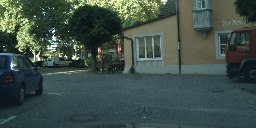
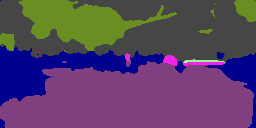
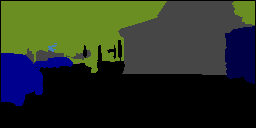
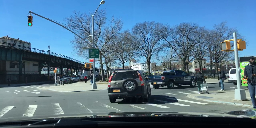
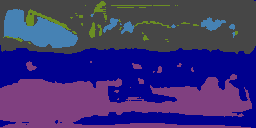
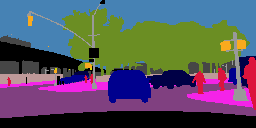
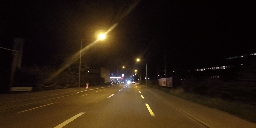
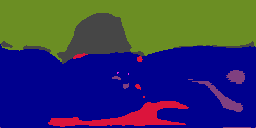
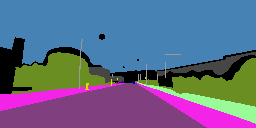
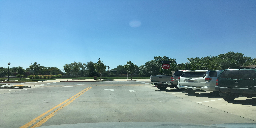
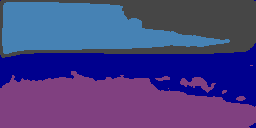
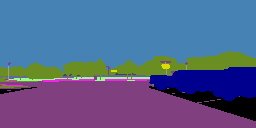

In [32]:
test_prediction(model, ['css_val', 'bdd', 'acdc', 'map'])